<h1>Bidirectional LSTM</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

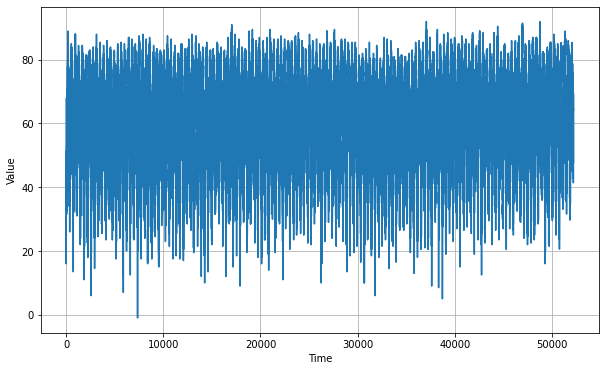

In [4]:
import csv
time_step = []
temps = []

with open('/content/drive/MyDrive/Birmingham-mean.csv') as csvfile:
###with open('Birmingham-mean.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 40000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=[None, 1], return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(40000,)
Epoch 1/100
156/156 [==============================] - 24s 75ms/step - loss: 1902.8656 - mae: 40.0971
Epoch 2/100
156/156 [==============================] - 7s 42ms/step - loss: 684.2125 - mae: 22.5153
Epoch 3/100
156/156 [==============================] - 8s 49ms/step - loss: 334.6678 - mae: 15.6068
Epoch 4/100
156/156 [==============================] - 7s 43ms/step - loss: 245.5780 - mae: 13.5287
Epoch 5/100
156/156 [==============================] - 7s 43ms/step - loss: 192.5598 - mae: 11.8181
Epoch 6/100
156/156 [==============================] - 7s 43ms/step - loss: 106.5465 - mae: 8.7398
Epoch 7/100
156/156 [==============================] - 7s 42ms/step - loss: 82.0361 - mae: 7.5212
Epoch 8/100
156/156 [==============================] - 7s 42ms/step - loss: 72.8984 - mae: 6.9193
Epoch 9/100
156/156 [=============

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 128)        33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [10]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

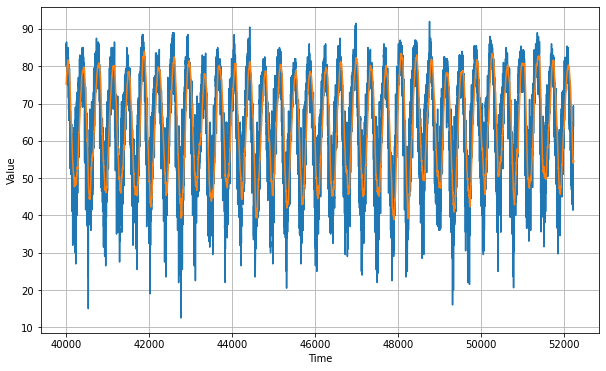

In [12]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.727791

mean absolute error = 7.727791

In [14]:
model.save('Bi_LSTM_model.h5')

In [15]:
model = tf.keras.models.load_model('Bi_LSTM_model.h5')